In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 40s 517ms/step - loss: 0.1460 - root_mean_squared_error: 0.3821 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 2/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0633 - root_mean_squared_error: 0.2516 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1825
Epoch 3/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1835
Epoch 4/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 5/50
53/53 [==============================] - 25s 474ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 6/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.0232 - val_

Epoch 36/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 37/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 38/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 39/50
53/53 [==============================] - 4s 74ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 40/50
53/53 [==============================] - 4s 69ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 41/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0106 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.261074562867483 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

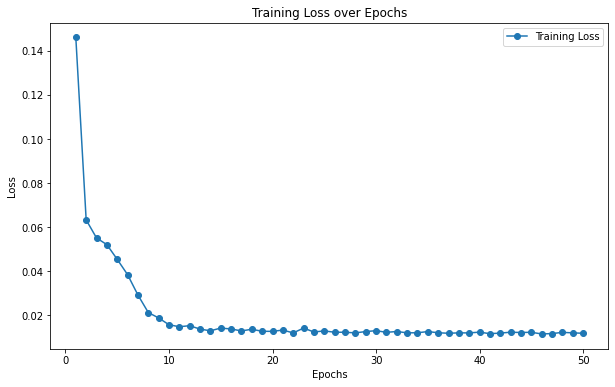

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

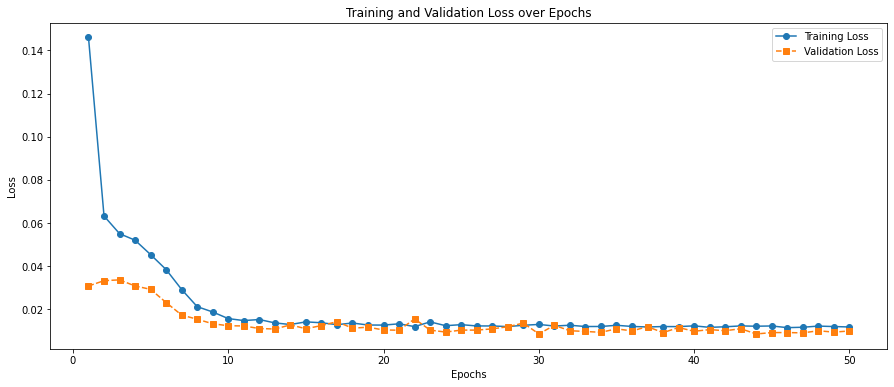

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 3s 40ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09448560582797186
MAE : 0.07901577788638195


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,105080.781250,242829.930
1,286993.750000,406860.687
2,411564.406250,605897.837
3,492729.375000,654073.790
4,538382.625000,701143.910
5,528406.812500,657891.340
6,442513.812500,432215.421
7,255671.593750,201834.787
8,56426.246094,55041.511
9,-56725.683594,5387.468


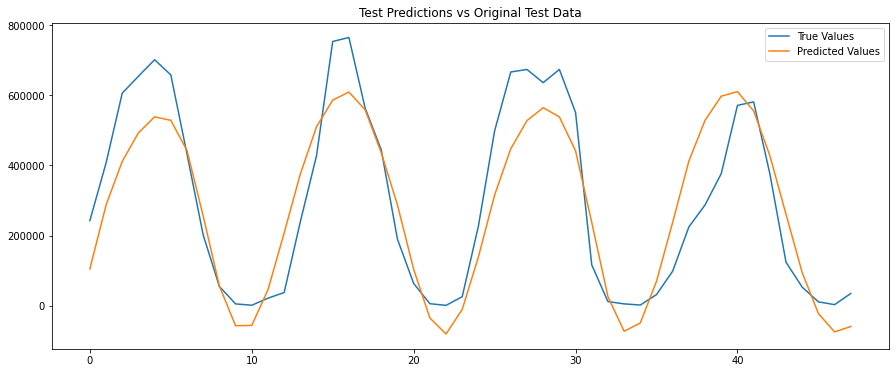

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 43ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

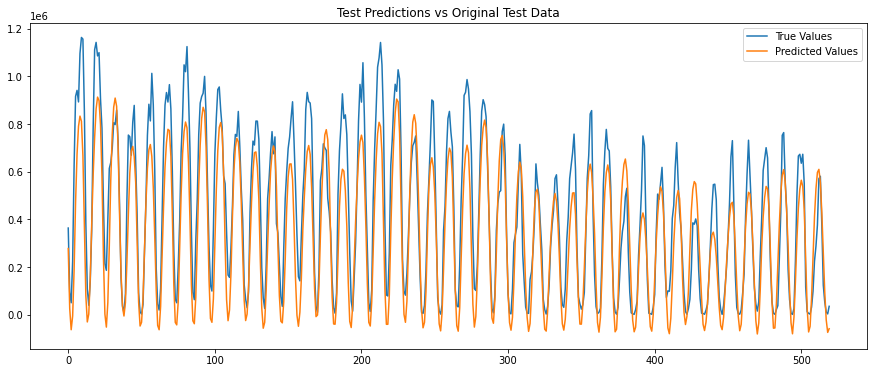

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()